In [1]:
import os
import cv2
import glob
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [1]:
# extracting the compressed dataset
dataset = '/train.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [2]:
# counting the number of files in train folder
path, dirs, files = next(os.walk('train'))
file_count = len(files)
print('Number of images: ', file_count)

Number of images:  25000


In [3]:
file_names = os.listdir('/content/train/')
print(file_names)

['dog.1305.jpg', 'cat.8537.jpg', 'dog.7756.jpg', 'cat.8141.jpg', 'dog.7760.jpg', 'dog.7796.jpg', 'dog.8944.jpg', 'cat.5081.jpg', 'cat.1944.jpg', 'dog.7010.jpg', 'cat.7489.jpg', 'cat.1915.jpg', 'dog.1802.jpg', 'cat.11749.jpg', 'cat.4896.jpg', 'cat.1141.jpg', 'dog.1259.jpg', 'cat.4112.jpg', 'dog.7388.jpg', 'cat.1897.jpg', 'dog.6193.jpg', 'cat.1958.jpg', 'dog.10747.jpg', 'dog.7055.jpg', 'cat.8147.jpg', 'cat.7400.jpg', 'dog.1642.jpg', 'dog.10748.jpg', 'dog.507.jpg', 'cat.18.jpg', 'dog.8789.jpg', 'dog.7543.jpg', 'cat.6288.jpg', 'dog.9018.jpg', 'dog.1941.jpg', 'cat.1132.jpg', 'cat.10543.jpg', 'cat.9044.jpg', 'dog.9602.jpg', 'dog.4994.jpg', 'dog.391.jpg', 'dog.7181.jpg', 'dog.3532.jpg', 'dog.9214.jpg', 'dog.11668.jpg', 'dog.1343.jpg', 'cat.11006.jpg', 'dog.4093.jpg', 'cat.3696.jpg', 'dog.7960.jpg', 'dog.316.jpg', 'cat.12217.jpg', 'cat.10345.jpg', 'cat.1153.jpg', 'cat.9514.jpg', 'cat.8714.jpg', 'cat.10699.jpg', 'dog.7372.jpg', 'dog.469.jpg', 'dog.9594.jpg', 'cat.9004.jpg', 'cat.8406.jpg', 'dog

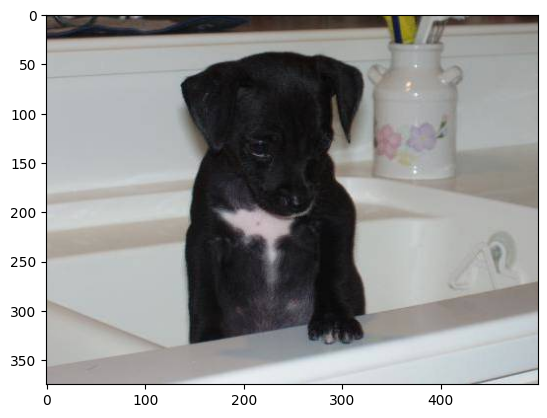

In [4]:
# display dog image
img = mpimg.imread('/content/train/dog.8298.jpg')
imgplt = plt.imshow(img)
plt.show()

In [5]:
file_names = os.listdir('/content/train/')

dog_count = 0
cat_count = 0

for img_file in file_names:
  name = img_file[0:3]
  if name == 'dog':
    dog_count += 1
  else:
    cat_count += 1

print('Number of dog images =', dog_count)
print('Number of cat images =', cat_count)

Number of dog images = 12500
Number of cat images = 12500


In [6]:
os.mkdir('/content/image-resized')

In [7]:
# Define the path for the original folder containing images
og_folder = '/content/train/'

# Define the path for the folder where resized images will be saved
resized_folder = '/content/image-resized/'

# Loop through the first 2500 images in the original folder
for i in range(2500):

  # Fetch the filename of the i-th image from the original folder
  filename = os.listdir(og_folder)[i]

  # Construct the complete path for the image
  img_path = og_folder+filename

  # Open the image using PIL's Image module
  img = Image.open(img_path)

  # Resize the image to 224x224 pixels
  img = img.resize((224, 224))

  # Convert the image mode to RGB (in case it's not RGB already)
  img = img.convert('RGB')

  # Construct the path where the resized image will be saved
  newImgPath = resized_folder+filename

  # Save the resized and converted image to the new path
  img.save(newImgPath)


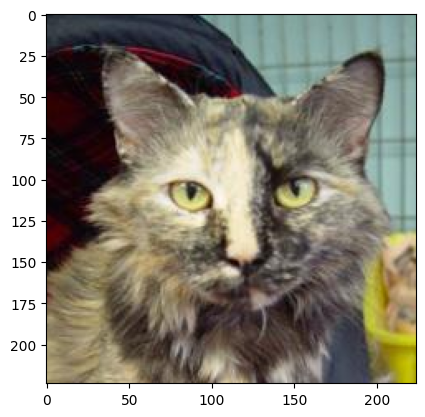

In [11]:
# display resized cat image
img = mpimg.imread('/content/image-resized/cat.10.jpg')
imgplt = plt.imshow(img)
plt.show()

In [12]:
# creaing a for loop to assign labels
filenames = os.listdir('/content/image-resized/')
labels = []

for i in range(2500):

  file_name = filenames[i]
  label = file_name[0:3]
  if label == 'dog':
    labels.append(1)
  else:
    labels.append(0)

In [13]:
# counting the images of dogs and cats out of 2000 images
values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)

[0 1]
[1253 1247]


In [14]:
# Setting the directory path where the images are located
img_directory = '/content/image-resized/'

# Defining the image file extensions we're interested in
img_extension = ['png', 'jpg']

# Initializing an empty list to store file paths
files = []

# Using list comprehension to find all image files with the given extensions and add them to the 'files' list
[files.extend(glob.glob(img_directory + '*.' + e)) for e in img_extension]

# Reading each image from the file paths and converting them to a numpy array
dog_cat_imgs = np.asarray([cv2.imread(file) for file in files])


In [15]:
x = dog_cat_imgs
y = np.asarray(labels)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state= 8)

In [17]:
# scaling the data
x_train_scaled = x_train/255
x_test_scaled = x_test/255

In [18]:
#loading the pretrained model
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3), trainable=False)

In [24]:
#building the model architecture
num_of_classes = 2

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_of_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='softmax')
])

# Learning rate scheduling (optional)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2265666 (8.64 MB)
Trainable params: 5122 (20.01 KB)
Non-trainable params: 2260544 (8.62 MB)
_________________________________________________________________


In [20]:
#training the model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

model.fit(x_train_scaled, y_train, epochs=5)

Epoch 1/5
63/63 [==============================] - 71s 1s/step - loss: 0.1603 - acc: 0.9400
Epoch 2/5
63/63 [==============================] - 70s 1s/step - loss: 0.0525 - acc: 0.9850
Epoch 3/5
63/63 [==============================] - 65s 1s/step - loss: 0.0409 - acc: 0.9890
Epoch 4/5
63/63 [==============================] - 66s 1s/step - loss: 0.0321 - acc: 0.9930
Epoch 5/5
63/63 [==============================] - 66s 1s/step - loss: 0.0274 - acc: 0.9945


In [21]:
#evaluating our model based on test accuracy and loss
score, acc = model.evaluate(x_test_scaled, y_test)
print('Test Loss: ', score)
print('Test Accuracy: ', acc)

16/16 [==============================] - 36s 2s/step - loss: 0.0573 - acc: 0.9820
Test Loss:  0.05726943910121918
Test Accuracy:  0.9819999933242798


Path of the image to be predicted: /content/train/dog.8298.jpg


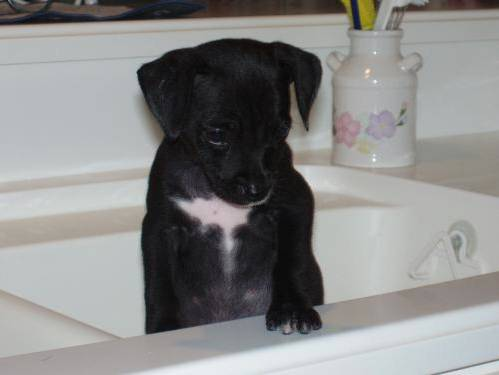

1/1 [==============================] - 1s 800ms/step
[[-2.4108334  0.6494834]]
1
Its a Dog


In [22]:
# Ask the user for the path of the image they want to be predicted
input_image_path = input('Path of the image to be predicted: ')

# Read the image using OpenCV
input_image = cv2.imread(input_image_path)

# Display the input image
cv2_imshow(input_image)

# Resize the image to a shape of 224x224 pixels which might be the required input shape for the model
input_image_resize = cv2.resize(input_image, (224,224))

# Scale the pixel values to be between 0 and 1 (typical preprocessing step)
input_image_scaled = input_image_resize/255

# Reshape the image to have a batch dimension (since many models expect a batch of images as input)
image_reshaped = np.reshape(input_image_scaled, [1,224,224,3])

# Predict the class of the input image using the pre-trained model
input_prediction = model.predict(image_reshaped)

# Print the raw prediction values
print(input_prediction)

# Find the index (label) of the maximum value in the prediction output
input_pred_label = np.argmax(input_prediction)
print(input_pred_label)

# Based on the label, determine if the image is a Cat or Dog and print the result
if input_pred_label == 0:
  print('Its a Cat')
else:
  print('Its a Dog')


Path of the image to be predicted: /content/image-resized/cat.10.jpg


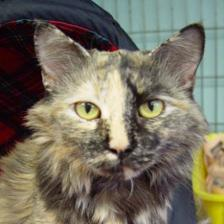

1/1 [==============================] - 0s 161ms/step
[[ 4.37458   -4.0601873]]
0
Its a Cat


In [23]:
#This does the same as the code above
input_image_path = input('Path of the image to be predicted: ')
input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

input_image_resize = cv2.resize(input_image, (224,224))
input_image_scaled = input_image_resize/255
image_reshaped = np.reshape(input_image_scaled, [1,224,224,3])

input_prediction = model.predict(image_reshaped)
print(input_prediction)

input_pred_label = np.argmax(input_prediction)
print(input_pred_label)

if input_pred_label == 0:
  print('Its a Cat')
else:
  print('Its a Dog')